{'uci_id': 294, 'name': 'Combined Cycle Power Plant', 'repository_url': 'https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant', 'data_url': 'https://archive.ics.uci.edu/static/public/294/data.csv', 'abstract': 'The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 9568, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['PE'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2014, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5002N', 'creators': ['Pnar Tfekci', 'Heysem Kaya'], 'intro_paper': {'ID': 406, 'type': 'NATIVE', 'title': 'Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods', 'aut

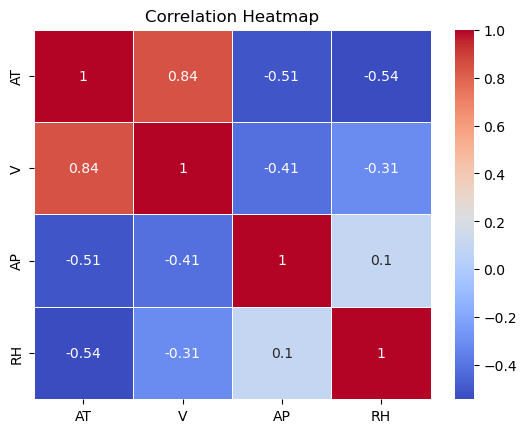

In [16]:
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt

# fetch dataset 
combined_cycle_power_plant = fetch_ucirepo(id=294) 
  
# data (as pandas dataframes) 
X = combined_cycle_power_plant.data.features 
y = combined_cycle_power_plant.data.targets 

X = X.rename(columns{'T':'Temperature',''
# metadata 
print(combined_cycle_power_plant.metadata) 

# variable information 
print(combined_cycle_power_plant.variables) 

sns.heatmap(X.corr(), annot=True, cmap = 'coolwarm', linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [3]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("Simple RF").getOrCreate()

# Load data
data = spark.read.csv("Power Plant Data.csv", header=True, inferSchema=True)
# data = data.withColumnRenamed('AT', 'Temperature(C)') \
#            .withColumnRenamed('V', 'Exhaust Vacuum(cmHg)') \
#            .withColumnRenamed('AP', 'Ambient Pressure(milibar)') \
#            .withColumnRenamed('RH', 'Relative Humidity(%)') \
#            .withColumnRenamed('PE', 'Electrical Power Output(MW)')

data.printSchema()
data.show(5)
# Create binary label (High vs Low PE)
median_value = data.approxQuantile("PE", [0.5], 0.01)[0]
data = data.withColumn("label", when(data.PE > median_value, 1).otherwise(0))

# Features
assembler = VectorAssembler(inputCols=["AT", "V", "AP", "RH"], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(
    featuresCol="scaledFeatures", 
    labelCol="label", 
    numTrees=100, 
    maxDepth=10, 
    seed=42)

rf_reg = RandomForestRegressor(
    featuresCol="scaledFeatures",
    labelCol="PE",
    numTrees=150,
    maxDepth=10,
    seed=42
)
reg_pipeline = Pipeline(stages=[assembler, scaler, rf_reg])

pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
predictions = model.transform(test_data)

train_time = end_time - start_time
print(f"Classification Model training completed in {train_time:.2f} seconds.")

start_time = time.time()
reg_model = reg_pipeline.fit(train_data)
end_time = time.time()
reg_pred = reg_model.transform(test_data)

train_time = end_time - start_time
print(f"Regression Model training completed in {train_time:.2f} seconds.")

# Evaluators
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator_acc.evaluate(predictions)
precision = evaluator_prec.evaluate(predictions)
recall = evaluator_rec.evaluate(predictions)
auc = evaluator_auc.evaluate(predictions)

print(f"Classification Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"AUC:       {auc:.3f}")

e_rmse = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="rmse")
e_mae  = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="mae")
e_r2   = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="r2")

rmse = e_rmse.evaluate(reg_pred)
mae  = e_mae.evaluate(reg_pred)
r2   = e_r2.evaluate(reg_pred)

print("Regression Metrics")
print(f"Train time (s): {reg_train_time:.2f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"R²  : {r2:.3f}")

spark.stop()


root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows


25/11/09 22:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1461.7 KiB
25/11/09 22:44:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/09 22:44:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
25/11/09 22:44:53 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Classification Model training completed in 9.48 seconds.


25/11/09 22:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1472.3 KiB
25/11/09 22:45:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/09 22:45:02 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
25/11/09 22:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB
25/11/09 22:45:06 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
25/11/09 22:45:07 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/09 22:45:11 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/11/09 22:45:13 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
                                                                                

Regression Model training completed in 23.10 seconds.


25/11/09 22:45:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/09 22:45:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/09 22:45:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/09 22:45:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Classification Metrics:
Accuracy:  0.960
Precision: 0.960
Recall:    0.960
AUC:       0.995
Regression Metrics


NameError: name 'reg_train_time' is not defined

In [2]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator

spark = SparkSession.builder.appName("Simple_LR_And_LogReg").getOrCreate()

# Load data
data = spark.read.csv("Power Plant Data.csv", header=True, inferSchema=True)
expected = {"AT", "V", "AP", "RH", "PE"}

feature_cols = ["AT", "V", "AP", "RH"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

reg_train, reg_test = data.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="scaledFeatures", labelCol="PE")
reg_pipe = Pipeline(stages=[assembler, scaler, lr])

start_time_0 = time.time()
reg_model = reg_pipe.fit(reg_train)
reg_time = time.time() - start_time_0

reg_preds = reg_model.transform(reg_test)

e_rmse = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="rmse")
e_mae  = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="mae")
e_r2   = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="r2")

rmse = e_rmse.evaluate(reg_preds)
mae  = e_mae.evaluate(reg_preds)
r2   = e_r2.evaluate(reg_preds)

print("Linear Regression):")
print(f"Train time (s): {reg_time:.2f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"R²  : {r2:.3f}")


median_pe = data.approxQuantile("PE", [0.5], 0.001)[0]
data_bin = data.withColumn("label_bin", when(col("PE") > median_pe, 1).otherwise(0))

cls_train, cls_test = data_bin.randomSplit([0.8, 0.2], seed=42)

logreg = LogisticRegression(
    featuresCol="scaledFeatures", 
    labelCol="label_bin", 
    maxIter=100)
cls_pipeline = Pipeline(stages=[assembler, scaler, logreg])

start_time = time.time()
cls_model = cls_pipeline.fit(cls_train)
cls_time = time.time() - start_time

cls_preds = cls_model.transform(cls_test).cache()

# Metrics
e_acc  = MulticlassClassificationEvaluator(labelCol="label_bin", 
                                           predictionCol="prediction", 
                                           metricName="accuracy")
e_prec = MulticlassClassificationEvaluator(labelCol="label_bin", 
                                           predictionCol="prediction", 
                                           metricName="weightedPrecision")
e_auc  = BinaryClassificationEvaluator(labelCol="label_bin", 
                                       rawPredictionCol="rawPrediction", 
                                       metricName="areaUnderROC")

accuracy  = e_acc.evaluate(cls_preds)
precision = e_prec.evaluate(cls_preds)
auc       = e_auc.evaluate(cls_preds)

print("Logistic Regression/ Classification:")
print(f"Train time (s): {cls_time:.2f}")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"AUC      : {auc:.3f}")

spark.stop()

25/11/09 22:44:08 WARN Instrumentation: [be1ee860] regParam is zero, which might cause numerical instability and overfitting.
25/11/09 22:44:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/09 22:44:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression):
Train time (s): 3.14
RMSE: 4.397
MAE : 3.572
R²  : 0.930
Logistic Regression/ Classification:
Train time (s): 4.29
Accuracy : 0.952
Precision: 0.952
AUC      : 0.991
